In [64]:
# ----------------------------------------
# 1. IMPORTAR LIBRERÍAS
# ----------------------------------------
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LeakyReLU, Multiply, Lambda, RepeatVector, BatchNormalization, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2  # Añadimos esta importación
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

# Configurar semillas aleatorias para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
# ----------------------------------------
# 2. CARGA Y PREPROCESAMIENTO DE DATOS
# ----------------------------------------
# Cargar el CSV y eliminar la columna DateTimes
df = pd.read_csv('./dataset_rttov_rad.csv')
df = df.drop(columns=['DateTimes'])

# Convertir columnas de texto a arrays numéricos
P_values    = np.array([np.array(eval(row)) for row in df['P']])
T_values    = np.array([np.array(eval(row)) for row in df['T']])
Q_values    = np.array([np.array(eval(row)) for row in df['Q']])
CO2_values  = np.array([np.array(eval(row)) for row in df['CO2']])
Angles      = np.array([np.array(eval(row)) for row in df['Angles']])
SurfGeom    = np.array([np.array(eval(row)) for row in df['SurfGeom']])
Skin        = np.array([np.array(eval(row)) for row in df['Skin']])
s2m         = np.array([np.array(eval(row)) for row in df['s2m']])
SurfType    = np.array([np.array(eval(row)) for row in df['SurfType']])

# Calcular medias
P_mean   = np.mean(P_values, axis=1)
T_mean   = np.mean(T_values, axis=1)
Q_mean   = np.mean(Q_values, axis=1)
CO2_mean = np.mean(CO2_values, axis=1)

# Crear DataFrames
SurfGeom_df = pd.DataFrame(SurfGeom, columns=[f"SurfGeom_{i}" for i in range(SurfGeom.shape[1])])
Angles_df   = pd.DataFrame(Angles,   columns=[f"Angles_{i}" for i in range(Angles.shape[1])])
Skin_df     = pd.DataFrame(Skin,     columns=[f"Skin_{i}" for i in range(Skin.shape[1])])
s2m_df      = pd.DataFrame(s2m,      columns=[f"s2m_{i}" for i in range(s2m.shape[1])])
SurfType_df = pd.DataFrame(SurfType, columns=[f"SurfType_{i}" for i in range(SurfType.shape[1])])

# Procesar resultados
Results    = np.array([np.array(eval(row)) for row in df['Result']])
results_df = pd.DataFrame(Results, columns=[f"Result_{i}" for i in range(Results.shape[1])])

# Crear DataFrame final
stats_df = pd.DataFrame({
    "P": P_mean, 
    "T": T_mean, 
    "Q": Q_mean,
    "CO2": CO2_mean
})

final_df = pd.concat([stats_df, SurfGeom_df, Angles_df, Skin_df, s2m_df, SurfType_df, results_df], axis=1)

# Limpiar columnas
final_df = final_df.drop(columns=['Skin_1', 'Skin_2', 'Skin_3', 'Skin_4', 'Skin_5', 
                                 'Skin_6', 'Skin_7', 'Skin_8', 's2m_3', 's2m_4', 's2m_5',
                                 'SurfType_1', 'CO2'])
final_df = final_df.drop(columns=['SurfGeom_2','s2m_0','Angles_1'])

print("Dimensiones del DataFrame final:", final_df.shape)
print("\nColumnas en el DataFrame final:")
print(final_df.columns.tolist())

Dimensiones del DataFrame final: (40000, 17)

Columnas en el DataFrame final:
['P', 'T', 'Q', 'SurfGeom_0', 'SurfGeom_1', 'Angles_0', 'Angles_2', 'Angles_3', 'Skin_0', 's2m_1', 's2m_2', 'SurfType_0', 'Result_0', 'Result_1', 'Result_2', 'Result_3', 'Result_4']


In [66]:
# ----------------------------------------
# 3. PREPARACIÓN DE DATOS PARA DEEPONET
# ----------------------------------------
# Separar features y target
X = final_df.drop(columns=['Result_0','Result_1','Result_2','Result_3','Result_4']).copy()
Y = final_df[['Result_0','Result_1','Result_2','Result_3','Result_4']].copy()

# Función de normalización robusta
def robust_normalize(data, axis=0):
    mean = np.mean(data, axis=axis)
    std = np.std(data, axis=axis)
    epsilon = 1e-8  # Para evitar división por cero
    return (data - mean) / (std + epsilon), mean, std

# Normalizar los datos
X_scaled, X_mean, X_std = robust_normalize(X.values)
Y_scaled, Y_mean, Y_std = robust_normalize(Y.values)

# División train/test después de la normalización
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y_scaled,
    test_size=0.2,
    random_state=42
)

# Preparar datos trunk
n_sensor = 5
trunk_coords = np.linspace(0, 1, n_sensor).reshape(n_sensor, 1)
trunk_train = np.repeat(trunk_coords[None, :, :], X_train.shape[0], axis=0)
trunk_test = np.repeat(trunk_coords[None, :, :], X_test.shape[0], axis=0)

# Verificar la normalización
print("Estadísticas de los datos normalizados:")
print("\nX_train:")
print(f"Media: {np.mean(X_train):.6f}")
print(f"Desviación estándar: {np.std(X_train):.6f}")
print("\nX_test:")
print(f"Media: {np.mean(X_test):.6f}")
print(f"Desviación estándar: {np.std(X_test):.6f}")
print("\nY_train:")
print(f"Media: {np.mean(Y_train):.6f}")
print(f"Desviación estándar: {np.std(Y_train):.6f}")
print("\nY_test:")
print(f"Media: {np.mean(Y_test):.6f}")
print(f"Desviación estándar: {np.std(Y_test):.6f}")

print("\nDimensiones de los datos:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"Y_test: {Y_test.shape}")
print(f"trunk_train: {trunk_train.shape}")
print(f"trunk_test: {trunk_test.shape}")

Estadísticas de los datos normalizados:

X_train:
Media: -0.000387
Desviación estándar: 0.971563

X_test:
Media: 0.001546
Desviación estándar: 0.975407

Y_train:
Media: 0.002576
Desviación estándar: 0.998017

Y_test:
Media: -0.010306
Desviación estándar: 1.007818

Dimensiones de los datos:
X_train: (32000, 12)
X_test: (8000, 12)
Y_train: (32000, 5)
Y_test: (8000, 5)
trunk_train: (32000, 5, 1)
trunk_test: (8000, 5, 1)


In [67]:
# ----------------------------------------
# 4. MODELO DEEPONET
# ----------------------------------------

def create_deeponet(input_dim, n_sensor):
    # Branch network
    branch_input = Input(shape=(input_dim,))
    branch = Dense(128, kernel_regularizer=l2(1e-4),
                  kernel_initializer='he_normal')(branch_input)
    branch = LeakyReLU(alpha=0.1)(branch)
    branch = BatchNormalization(momentum=0.9)(branch)
    branch = Dropout(0.1)(branch)

    branch = Dense(256, kernel_regularizer=l2(1e-4),
                  kernel_initializer='he_normal')(branch)
    branch = LeakyReLU(alpha=0.1)(branch)
    branch = BatchNormalization(momentum=0.9)(branch)
    branch = Dropout(0.1)(branch)
    branch = Dense(128, kernel_regularizer=l2(1e-4),
                  kernel_initializer='he_normal')(branch)
    branch = LeakyReLU(alpha=0.1)(branch)
    branch = BatchNormalization(momentum=0.9)(branch)
    branch = Dense(32)(branch)

    # Trunk network
    trunk_input = Input(shape=(n_sensor, 1))
    trunk = Dense(128, kernel_initializer='he_normal')(trunk_input)
    trunk = LeakyReLU(alpha=0.1)(trunk)
    trunk = BatchNormalization(momentum=0.9)(trunk)
    trunk = Dense(128, kernel_initializer='he_normal')(trunk)
    trunk = LeakyReLU(alpha=0.1)(trunk)
    trunk = BatchNormalization(momentum=0.9)(trunk)
    trunk = Dense(32)(trunk)

    # Expandir branch para que coincida con la dimensión del trunk
    branch_expanded = RepeatVector(n_sensor)(branch)

    output = Multiply()([branch_expanded, trunk])
    output = Dense(32, activation='relu')(output)
    output = Dense(5)(output)
    output = Lambda(lambda x: x[:, 0, :])(output)

    return Model(inputs=[branch_input, trunk_input], outputs=output)

# Crear y compilar modelo
n_sensor = 5
trunk_coords = np.linspace(0, 1, n_sensor).reshape(-1, 1)  # Shape: (5, 1)

# Preparar datos de entrenamiento
trunk_train = np.tile(trunk_coords, (X_train.shape[0], 1))  # Shape: (n_samples, 5)
trunk_train = trunk_train.reshape(X_train.shape[0], n_sensor, 1)  # Shape: (n_samples, 5, 1)

# Preparar datos de prueba
trunk_test = np.tile(trunk_coords, (X_test.shape[0], 1))  # Shape: (n_samples, 5)
trunk_test = trunk_test.reshape(X_test.shape[0], n_sensor, 1)  # Shape: (n_samples, 5, 1)

"""
# Crear y compilar modelo
model = create_deeponet(input_dim=X_train.shape[1], n_sensor=n_sensor)
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)
"""

"\n# Crear y compilar modelo\nmodel = create_deeponet(input_dim=X_train.shape[1], n_sensor=n_sensor)\nmodel.compile(\n    optimizer='adam',\n    loss='mse',\n    metrics=['mae']\n)\n"

In [68]:
# ----------------------------------------
# 5. ENTRENAMIENTO
# ----------------------------------------
# Learning rate con schedule
#initial_learning_rate = 0.001


# Mezclar los datos antes de dividir
indices = np.arange(len(X_scaled))
np.random.shuffle(indices)
X_scaled = X_scaled[indices]
Y_scaled = Y_scaled[indices]

# División inicial en train y test
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y_scaled,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 2. Ajustar el batch size y el learning rate
batch_size = 128  # Aumentar el batch size para más estabilidad
initial_learning_rate = 0.0005  # Reducir el learning rate inicial

# 3. Modificar el optimizador y los callbacksß
optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
    weight_decay=1e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=True 
)

# Compilar con configuración mejorada
model = create_deeponet(input_dim=X_train.shape[1], n_sensor=n_sensor)

model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

# Callbacks mejorados
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True,
        min_delta=1e-4,
        mode='min'
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=10,
        min_lr=1e-6,
        verbose=1,
        mode='min'
    )
]

start_time = time.time()


history = model.fit(
    [X_train, trunk_train],
    Y_train,
    epochs=500,
    batch_size=batch_size,
    validation_split=0.2,
    shuffle=True,  # Asegurar que los datos se mezclen en cada época
    callbacks=callbacks,
    verbose=1
) 

end_time = time.time()
print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

Epoch 1/500


/Users/esther/Documents/Mis-cosas/TFM/.venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6217 - mae: 0.4473 - mse: 0.5184

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.6091 - mae: 0.4406 - mse: 0.5058 - val_loss: 0.1704 - val_mae: 0.1596 - val_mse: 0.0680 - learning_rate: 5.0000e-04
Epoch 2/500
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1750 - mae: 0.1786 - mse: 0.0729

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1749 - mae: 0.1786 - mse: 0.0729 - val_loss: 0.1545 - val_mae: 0.1409 - val_mse: 0.0539 - learning_rate: 5.0000e-04
Epoch 3/500
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1615 - mae: 0.1624 - mse: 0.0614

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1614 - mae: 0.1624 - mse: 0.0614 - val_loss: 0.1412 - val_mae: 0.1242 - val_mse: 0.0428 - learning_rate: 5.0000e-04
Epoch 4/500
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1524 - mae: 0.1532 - mse: 0.0545

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1524 - mae: 0.1532 - mse: 0.0545 - val_loss: 0.1334 - val_mae: 0.1140 - val_mse: 0.0373 - learning_rate: 5.0000e-04
Epoch 5/500
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1451 - mae: 0.1449 - mse: 0.0497

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1451 - mae: 0.1449 - mse: 0.0497 - val_loss: 0.1285 - val_mae: 0.1096 - val_mse: 0.0349 - learning_rate: 5.0000e-04
Epoch 6/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1395 - mae: 0.1389 - mse: 0.0465

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1395 - mae: 0.1389 - mse: 0.0466 - val_loss: 0.1248 - val_mae: 0.1073 - val_mse: 0.0337 - learning_rate: 5.0000e-04
Epoch 7/500
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1345 - mae: 0.1337 - mse: 0.0440

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1345 - mae: 0.1337 - mse: 0.0440 - val_loss: 0.1213 - val_mae: 0.1050 - val_mse: 0.0327 - learning_rate: 5.0000e-04
Epoch 8/500
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1298 - mae: 0.1301 - mse: 0.0419

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1298 - mae: 0.1302 - mse: 0.0419 - val_loss: 0.1176 - val_mae: 0.1015 - val_mse: 0.0315 - learning_rate: 5.0000e-04
Epoch 9/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1252 - mae: 0.1254 - mse: 0.0397

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1252 - mae: 0.1255 - mse: 0.0397 - val_loss: 0.1149 - val_mae: 0.1018 - val_mse: 0.0312 - learning_rate: 5.0000e-04
Epoch 10/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1221 - mae: 0.1236 - mse: 0.0390

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1221 - mae: 0.1236 - mse: 0.0390 - val_loss: 0.1123 - val_mae: 0.1016 - val_mse: 0.0310 - learning_rate: 5.0000e-04
Epoch 11/500
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1188 - mae: 0.1214 - mse: 0.0380

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1188 - mae: 0.1214 - mse: 0.0380 - val_loss: 0.1098 - val_mae: 0.1012 - val_mse: 0.0307 - learning_rate: 5.0000e-04
Epoch 12/500
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1156 - mae: 0.1197 - mse: 0.0371

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1156 - mae: 0.1198 - mse: 0.0372 - val_loss: 0.1071 - val_mae: 0.1000 - val_mse: 0.0303 - learning_rate: 5.0000e-04
Epoch 13/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1133 - mae: 0.1187 - mse: 0.0370

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1133 - mae: 0.1188 - mse: 0.0370 - val_loss: 0.1048 - val_mae: 0.0986 - val_mse: 0.0302 - learning_rate: 5.0000e-04
Epoch 14/500
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1100 - mae: 0.1164 - mse: 0.0358

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1100 - mae: 0.1165 - mse: 0.0358 - val_loss: 0.1020 - val_mae: 0.0984 - val_mse: 0.0294 - learning_rate: 5.0000e-04
Epoch 15/500
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1072 - mae: 0.1158 - mse: 0.0350

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1072 - mae: 0.1159 - mse: 0.0351 - val_loss: 0.1002 - val_mae: 0.0984 - val_mse: 0.0296 - learning_rate: 5.0000e-04
Epoch 16/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1052 - mae: 0.1152 - mse: 0.0351

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1052 - mae: 0.1153 - mse: 0.0351 - val_loss: 0.0980 - val_mae: 0.0973 - val_mse: 0.0293 - learning_rate: 5.0000e-04
Epoch 17/500
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1029 - mae: 0.1147 - mse: 0.0347

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1029 - mae: 0.1147 - mse: 0.0347 - val_loss: 0.0949 - val_mae: 0.0940 - val_mse: 0.0281 - learning_rate: 5.0000e-04
Epoch 18/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1007 - mae: 0.1130 - mse: 0.0343

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1007 - mae: 0.1131 - mse: 0.0343 - val_loss: 0.0939 - val_mae: 0.0961 - val_mse: 0.0288 - learning_rate: 5.0000e-04
Epoch 19/500
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0987 - mae: 0.1122 - mse: 0.0340

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0986 - mae: 0.1122 - mse: 0.0340 - val_loss: 0.0919 - val_mae: 0.0950 - val_mse: 0.0285 - learning_rate: 5.0000e-04
Epoch 20/500
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0968 - mae: 0.1120 - mse: 0.0338

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0968 - mae: 0.1121 - mse: 0.0338 - val_loss: 0.0902 - val_mae: 0.0956 - val_mse: 0.0285 - learning_rate: 5.0000e-04
Epoch 21/500
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0940 - mae: 0.1104 - mse: 0.0327

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0940 - mae: 0.1104 - mse: 0.0327 - val_loss: 0.0877 - val_mae: 0.0946 - val_mse: 0.0275 - learning_rate: 5.0000e-04
Epoch 22/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0926 - mae: 0.1095 - mse: 0.0329

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0926 - mae: 0.1095 - mse: 0.0329 - val_loss: 0.0866 - val_mae: 0.0944 - val_mse: 0.0280 - learning_rate: 5.0000e-04
Epoch 23/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0908 - mae: 0.1091 - mse: 0.0325

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0908 - mae: 0.1092 - mse: 0.0325 - val_loss: 0.0849 - val_mae: 0.0947 - val_mse: 0.0277 - learning_rate: 5.0000e-04
Epoch 24/500
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0884 - mae: 0.1079 - mse: 0.0317

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0884 - mae: 0.1079 - mse: 0.0317 - val_loss: 0.0826 - val_mae: 0.0930 - val_mse: 0.0269 - learning_rate: 5.0000e-04
Epoch 25/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0872 - mae: 0.1077 - mse: 0.0318

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0872 - mae: 0.1077 - mse: 0.0318 - val_loss: 0.0814 - val_mae: 0.0933 - val_mse: 0.0271 - learning_rate: 5.0000e-04
Epoch 26/500
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0855 - mae: 0.1067 - mse: 0.0315

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0855 - mae: 0.1067 - mse: 0.0315 - val_loss: 0.0798 - val_mae: 0.0922 - val_mse: 0.0268 - learning_rate: 5.0000e-04
Epoch 27/500
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0836 - mae: 0.1058 - mse: 0.0309

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0836 - mae: 0.1058 - mse: 0.0309 - val_loss: 0.0783 - val_mae: 0.0913 - val_mse: 0.0265 - learning_rate: 5.0000e-04
Epoch 28/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0820 - mae: 0.1055 - mse: 0.0306

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0820 - mae: 0.1055 - mse: 0.0306 - val_loss: 0.0771 - val_mae: 0.0913 - val_mse: 0.0266 - learning_rate: 5.0000e-04
Epoch 29/500
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0809 - mae: 0.1055 - mse: 0.0307

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0809 - mae: 0.1055 - mse: 0.0307 - val_loss: 0.0756 - val_mae: 0.0915 - val_mse: 0.0263 - learning_rate: 5.0000e-04
Epoch 30/500
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0797 - mae: 0.1057 - mse: 0.0307

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0797 - mae: 0.1057 - mse: 0.0307 - val_loss: 0.0743 - val_mae: 0.0909 - val_mse: 0.0262 - learning_rate: 5.0000e-04
Epoch 31/500
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0783 - mae: 0.1052 - mse: 0.0304

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0783 - mae: 0.1052 - mse: 0.0304 - val_loss: 0.0732 - val_mae: 0.0913 - val_mse: 0.0261 - learning_rate: 5.0000e-04
Epoch 32/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0769 - mae: 0.1044 - mse: 0.0301

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0769 - mae: 0.1044 - mse: 0.0301 - val_loss: 0.0714 - val_mae: 0.0889 - val_mse: 0.0254 - learning_rate: 5.0000e-04
Epoch 33/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0752 - mae: 0.1030 - mse: 0.0294

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0752 - mae: 0.1030 - mse: 0.0294 - val_loss: 0.0703 - val_mae: 0.0884 - val_mse: 0.0253 - learning_rate: 5.0000e-04
Epoch 34/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0736 - mae: 0.1021 - mse: 0.0289

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0736 - mae: 0.1021 - mse: 0.0289 - val_loss: 0.0689 - val_mae: 0.0878 - val_mse: 0.0249 - learning_rate: 5.0000e-04
Epoch 35/500
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0728 - mae: 0.1022 - mse: 0.0291

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0728 - mae: 0.1023 - mse: 0.0291 - val_loss: 0.0682 - val_mae: 0.0885 - val_mse: 0.0252 - learning_rate: 5.0000e-04
Epoch 36/500
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0719 - mae: 0.1018 - mse: 0.0291

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0718 - mae: 0.1019 - mse: 0.0291 - val_loss: 0.0665 - val_mae: 0.0863 - val_mse: 0.0244 - learning_rate: 5.0000e-04
Epoch 37/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0705 - mae: 0.1009 - mse: 0.0287

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0705 - mae: 0.1010 - mse: 0.0287 - val_loss: 0.0663 - val_mae: 0.0913 - val_mse: 0.0252 - learning_rate: 5.0000e-04
Epoch 38/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0694 - mae: 0.1010 - mse: 0.0285

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0694 - mae: 0.1011 - mse: 0.0285 - val_loss: 0.0649 - val_mae: 0.0881 - val_mse: 0.0246 - learning_rate: 5.0000e-04
Epoch 39/500
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0682 - mae: 0.1008 - mse: 0.0281

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0682 - mae: 0.1008 - mse: 0.0281 - val_loss: 0.0638 - val_mae: 0.0874 - val_mse: 0.0244 - learning_rate: 5.0000e-04
Epoch 40/500
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0672 - mae: 0.1003 - mse: 0.0280

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0672 - mae: 0.1003 - mse: 0.0280 - val_loss: 0.0630 - val_mae: 0.0885 - val_mse: 0.0245 - learning_rate: 5.0000e-04
Epoch 41/500
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0662 - mae: 0.0999 - mse: 0.0278

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0662 - mae: 0.0999 - mse: 0.0278 - val_loss: 0.0618 - val_mae: 0.0871 - val_mse: 0.0241 - learning_rate: 5.0000e-04
Epoch 42/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0654 - mae: 0.0995 - mse: 0.0279

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0654 - mae: 0.0995 - mse: 0.0279 - val_loss: 0.0609 - val_mae: 0.0878 - val_mse: 0.0240 - learning_rate: 5.0000e-04
Epoch 43/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0647 - mae: 0.1001 - mse: 0.0279

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0647 - mae: 0.1001 - mse: 0.0279 - val_loss: 0.0600 - val_mae: 0.0861 - val_mse: 0.0238 - learning_rate: 5.0000e-04
Epoch 44/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0635 - mae: 0.0986 - mse: 0.0275 - val_loss: 0.0602 - val_mae: 0.0877 - val_mse: 0.0247 - learning_rate: 5.0000e-04
Epoch 45/500
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0628 - mae: 0.0983 - mse: 0.0275

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0628 - mae: 0.0984 - mse: 0.0275 - val_loss: 0.0582 - val_mae: 0.0848 - val_mse: 0.0235 - learning_rate: 5.0000e-04
Epoch 46/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0614 - mae: 0.0977 - mse: 0.0268

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0614 - mae: 0.0977 - mse: 0.0268 - val_loss: 0.0578 - val_mae: 0.0849 - val_mse: 0.0238 - learning_rate: 5.0000e-04
Epoch 47/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0610 - mae: 0.0975 - mse: 0.0271

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0610 - mae: 0.0976 - mse: 0.0271 - val_loss: 0.0574 - val_mae: 0.0876 - val_mse: 0.0240 - learning_rate: 5.0000e-04
Epoch 48/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0602 - mae: 0.0976 - mse: 0.0270

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0602 - mae: 0.0977 - mse: 0.0270 - val_loss: 0.0567 - val_mae: 0.0874 - val_mse: 0.0239 - learning_rate: 5.0000e-04
Epoch 49/500
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0589 - mae: 0.0972 - mse: 0.0263

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0589 - mae: 0.0973 - mse: 0.0263 - val_loss: 0.0561 - val_mae: 0.0853 - val_mse: 0.0240 - learning_rate: 5.0000e-04
Epoch 50/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0583 - mae: 0.0969 - mse: 0.0263

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0583 - mae: 0.0969 - mse: 0.0263 - val_loss: 0.0557 - val_mae: 0.0877 - val_mse: 0.0243 - learning_rate: 5.0000e-04
Epoch 51/500
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0583 - mae: 0.0972 - mse: 0.0269

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0583 - mae: 0.0972 - mse: 0.0269 - val_loss: 0.0547 - val_mae: 0.0866 - val_mse: 0.0238 - learning_rate: 5.0000e-04
Epoch 52/500
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0576 - mae: 0.0973 - mse: 0.0269

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0576 - mae: 0.0973 - mse: 0.0269 - val_loss: 0.0542 - val_mae: 0.0862 - val_mse: 0.0239 - learning_rate: 5.0000e-04
Epoch 53/500
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0564 - mae: 0.0966 - mse: 0.0262

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0564 - mae: 0.0967 - mse: 0.0262 - val_loss: 0.0538 - val_mae: 0.0860 - val_mse: 0.0240 - learning_rate: 5.0000e-04
Epoch 54/500
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0557 - mae: 0.0962 - mse: 0.0261

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0558 - mae: 0.0962 - mse: 0.0262 - val_loss: 0.0531 - val_mae: 0.0880 - val_mse: 0.0239 - learning_rate: 5.0000e-04
Epoch 55/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0557 - mae: 0.0966 - mse: 0.0266

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0557 - mae: 0.0966 - mse: 0.0266 - val_loss: 0.0519 - val_mae: 0.0856 - val_mse: 0.0233 - learning_rate: 5.0000e-04
Epoch 56/500
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0550 - mae: 0.0959 - mse: 0.0264

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0549 - mae: 0.0959 - mse: 0.0264 - val_loss: 0.0515 - val_mae: 0.0851 - val_mse: 0.0234 - learning_rate: 5.0000e-04
Epoch 57/500
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0538 - mae: 0.0953 - mse: 0.0258

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0538 - mae: 0.0954 - mse: 0.0258 - val_loss: 0.0506 - val_mae: 0.0850 - val_mse: 0.0230 - learning_rate: 5.0000e-04
Epoch 58/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0534 - mae: 0.0949 - mse: 0.0259 - val_loss: 0.0510 - val_mae: 0.0853 - val_mse: 0.0239 - learning_rate: 5.0000e-04
Epoch 59/500
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0531 - mae: 0.0954 - mse: 0.0261

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0531 - mae: 0.0954 - mse: 0.0261 - val_loss: 0.0500 - val_mae: 0.0855 - val_mse: 0.0234 - learning_rate: 5.0000e-04
Epoch 60/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0523 - mae: 0.0955 - mse: 0.0258

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0523 - mae: 0.0955 - mse: 0.0258 - val_loss: 0.0495 - val_mae: 0.0856 - val_mse: 0.0233 - learning_rate: 5.0000e-04
Epoch 61/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0521 - mae: 0.0949 - mse: 0.0260

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0521 - mae: 0.0949 - mse: 0.0260 - val_loss: 0.0491 - val_mae: 0.0831 - val_mse: 0.0234 - learning_rate: 5.0000e-04
Epoch 62/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0511 - mae: 0.0938 - mse: 0.0254

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0511 - mae: 0.0938 - mse: 0.0254 - val_loss: 0.0488 - val_mae: 0.0865 - val_mse: 0.0235 - learning_rate: 5.0000e-04
Epoch 63/500
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0510 - mae: 0.0947 - mse: 0.0259

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0510 - mae: 0.0947 - mse: 0.0259 - val_loss: 0.0481 - val_mae: 0.0837 - val_mse: 0.0233 - learning_rate: 5.0000e-04
Epoch 64/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0500 - mae: 0.0934 - mse: 0.0253 - val_loss: 0.0484 - val_mae: 0.0837 - val_mse: 0.0240 - learning_rate: 5.0000e-04
Epoch 65/500
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0499 - mae: 0.0942 - mse: 0.0256

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0499 - mae: 0.0942 - mse: 0.0256 - val_loss: 0.0474 - val_mae: 0.0862 - val_mse: 0.0234 - learning_rate: 5.0000e-04
Epoch 66/500
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0491 - mae: 0.0936 - mse: 0.0252

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0491 - mae: 0.0936 - mse: 0.0252 - val_loss: 0.0471 - val_mae: 0.0849 - val_mse: 0.0235 - learning_rate: 5.0000e-04
Epoch 67/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0486 - mae: 0.0938 - mse: 0.0251

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0486 - mae: 0.0939 - mse: 0.0251 - val_loss: 0.0464 - val_mae: 0.0834 - val_mse: 0.0232 - learning_rate: 5.0000e-04
Epoch 68/500
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0484 - mae: 0.0935 - mse: 0.0253

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0484 - mae: 0.0936 - mse: 0.0253 - val_loss: 0.0462 - val_mae: 0.0850 - val_mse: 0.0234 - learning_rate: 5.0000e-04
Epoch 69/500
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0477 - mae: 0.0935 - mse: 0.0249

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0477 - mae: 0.0935 - mse: 0.0249 - val_loss: 0.0456 - val_mae: 0.0847 - val_mse: 0.0231 - learning_rate: 5.0000e-04
Epoch 70/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0474 - mae: 0.0933 - mse: 0.0251 - val_loss: 0.0458 - val_mae: 0.0872 - val_mse: 0.0237 - learning_rate: 5.0000e-04
Epoch 71/500
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0473 - mae: 0.0936 - mse: 0.0253

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0473 - mae: 0.0937 - mse: 0.0253 - val_loss: 0.0452 - val_mae: 0.0851 - val_mse: 0.0234 - learning_rate: 5.0000e-04
Epoch 72/500
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0465 - mae: 0.0932 - mse: 0.0248

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0465 - mae: 0.0932 - mse: 0.0249 - val_loss: 0.0445 - val_mae: 0.0842 - val_mse: 0.0231 - learning_rate: 5.0000e-04
Epoch 73/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0461 - mae: 0.0925 - mse: 0.0247 - val_loss: 0.0449 - val_mae: 0.0854 - val_mse: 0.0239 - learning_rate: 5.0000e-04
Epoch 74/500
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0456 - mae: 0.0921 - mse: 0.0246

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0456 - mae: 0.0921 - mse: 0.0246 - val_loss: 0.0442 - val_mae: 0.0846 - val_mse: 0.0235 - learning_rate: 5.0000e-04
Epoch 75/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0454 - mae: 0.0923 - mse: 0.0248

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0454 - mae: 0.0924 - mse: 0.0248 - val_loss: 0.0437 - val_mae: 0.0856 - val_mse: 0.0233 - learning_rate: 5.0000e-04
Epoch 76/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0450 - mae: 0.0920 - mse: 0.0246

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0450 - mae: 0.0920 - mse: 0.0246 - val_loss: 0.0433 - val_mae: 0.0850 - val_mse: 0.0232 - learning_rate: 5.0000e-04
Epoch 77/500
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0451 - mae: 0.0929 - mse: 0.0251

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0451 - mae: 0.0929 - mse: 0.0251 - val_loss: 0.0432 - val_mae: 0.0850 - val_mse: 0.0234 - learning_rate: 5.0000e-04
Epoch 78/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0446 - mae: 0.0921 - mse: 0.0249

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0446 - mae: 0.0921 - mse: 0.0249 - val_loss: 0.0431 - val_mae: 0.0859 - val_mse: 0.0236 - learning_rate: 5.0000e-04
Epoch 79/500
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0441 - mae: 0.0918 - mse: 0.0247

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0441 - mae: 0.0918 - mse: 0.0247 - val_loss: 0.0419 - val_mae: 0.0837 - val_mse: 0.0227 - learning_rate: 5.0000e-04
Epoch 80/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0443 - mae: 0.0923 - mse: 0.0252 - val_loss: 0.0423 - val_mae: 0.0852 - val_mse: 0.0234 - learning_rate: 5.0000e-04
Epoch 81/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0434 - mae: 0.0921 - mse: 0.0246

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0434 - mae: 0.0921 - mse: 0.0246 - val_loss: 0.0418 - val_mae: 0.0853 - val_mse: 0.0231 - learning_rate: 5.0000e-04
Epoch 82/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0428 - mae: 0.0909 - mse: 0.0242

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0428 - mae: 0.0909 - mse: 0.0242 - val_loss: 0.0413 - val_mae: 0.0844 - val_mse: 0.0229 - learning_rate: 5.0000e-04
Epoch 83/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0426 - mae: 0.0912 - mse: 0.0243

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0426 - mae: 0.0912 - mse: 0.0243 - val_loss: 0.0409 - val_mae: 0.0827 - val_mse: 0.0228 - learning_rate: 5.0000e-04
Epoch 84/500
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0420 - mae: 0.0916 - mse: 0.0240

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0420 - mae: 0.0916 - mse: 0.0240 - val_loss: 0.0407 - val_mae: 0.0831 - val_mse: 0.0228 - learning_rate: 5.0000e-04
Epoch 85/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0428 - mae: 0.0919 - mse: 0.0250 - val_loss: 0.0408 - val_mae: 0.0844 - val_mse: 0.0232 - learning_rate: 5.0000e-04
Epoch 86/500
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0418 - mae: 0.0914 - mse: 0.0242

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0418 - mae: 0.0914 - mse: 0.0242 - val_loss: 0.0406 - val_mae: 0.0849 - val_mse: 0.0232 - learning_rate: 5.0000e-04
Epoch 87/500
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0412 - mae: 0.0910 - mse: 0.0240

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0412 - mae: 0.0910 - mse: 0.0240 - val_loss: 0.0398 - val_mae: 0.0830 - val_mse: 0.0227 - learning_rate: 5.0000e-04
Epoch 88/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0414 - mae: 0.0918 - mse: 0.0244 - val_loss: 0.0400 - val_mae: 0.0838 - val_mse: 0.0232 - learning_rate: 5.0000e-04
Epoch 89/500
189/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0409 - mae: 0.0914 - mse: 0.0241

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0409 - mae: 0.0914 - mse: 0.0241 - val_loss: 0.0395 - val_mae: 0.0821 - val_mse: 0.0229 - learning_rate: 5.0000e-04
Epoch 90/500
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0401 - mae: 0.0901 - mse: 0.0235

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0401 - mae: 0.0901 - mse: 0.0235 - val_loss: 0.0391 - val_mae: 0.0827 - val_mse: 0.0227 - learning_rate: 5.0000e-04
Epoch 91/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0396 - mae: 0.0901 - mse: 0.0233 - val_loss: 0.0392 - val_mae: 0.0817 - val_mse: 0.0230 - learning_rate: 5.0000e-04
Epoch 92/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0402 - mae: 0.0904 - mse: 0.0241 - val_loss: 0.0393 - val_mae: 0.0844 - val_mse: 0.0233 - learning_rate: 5.0000e-04
Epoch 93/500
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0397 - mae: 0.0897 - mse: 0.0237

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0397 - mae: 0.0898 - mse: 0.0237 - val_loss: 0.0381 - val_mae: 0.0826 - val_mse: 0.0224 - learning_rate: 5.0000e-04
Epoch 94/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0398 - mae: 0.0909 - mse: 0.0241 - val_loss: 0.0387 - val_mae: 0.0845 - val_mse: 0.0232 - learning_rate: 5.0000e-04
Epoch 95/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0393 - mae: 0.0907 - mse: 0.0238 - val_loss: 0.0386 - val_mae: 0.0854 - val_mse: 0.0233 - learning_rate: 5.0000e-04
Epoch 96/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0392 - mae: 0.0898 - mse: 0.0239 - val_loss: 0.0384 - val_mae: 0.0862 - val_mse: 0.0232 - learning_rate: 5.0000e-04
Epoch 97/500
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0391 - mae: 0.0905 - mse: 0.0240

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0391 - mae: 0.0905 - mse: 0.0240 - val_loss: 0.0372 - val_mae: 0.0819 - val_mse: 0.0222 - learning_rate: 5.0000e-04
Epoch 98/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0384 - mae: 0.0894 - mse: 0.0235 - val_loss: 0.0381 - val_mae: 0.0841 - val_mse: 0.0234 - learning_rate: 5.0000e-04
Epoch 99/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0384 - mae: 0.0896 - mse: 0.0237 - val_loss: 0.0376 - val_mae: 0.0828 - val_mse: 0.0231 - learning_rate: 5.0000e-04
Epoch 100/500
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0380 - mae: 0.0892 - mse: 0.0235

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0380 - mae: 0.0892 - mse: 0.0235 - val_loss: 0.0369 - val_mae: 0.0829 - val_mse: 0.0225 - learning_rate: 5.0000e-04
Epoch 101/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0382 - mae: 0.0900 - mse: 0.0238 - val_loss: 0.0385 - val_mae: 0.0863 - val_mse: 0.0243 - learning_rate: 5.0000e-04
Epoch 102/500
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0376 - mae: 0.0890 - mse: 0.0234

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0376 - mae: 0.0890 - mse: 0.0234 - val_loss: 0.0361 - val_mae: 0.0803 - val_mse: 0.0221 - learning_rate: 5.0000e-04
Epoch 103/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0376 - mae: 0.0890 - mse: 0.0236 - val_loss: 0.0366 - val_mae: 0.0833 - val_mse: 0.0227 - learning_rate: 5.0000e-04
Epoch 104/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0379 - mae: 0.0895 - mse: 0.0240 - val_loss: 0.0365 - val_mae: 0.0834 - val_mse: 0.0228 - learning_rate: 5.0000e-04
Epoch 105/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0372 - mae: 0.0893 - mse: 0.0235 - val_loss: 0.0363 - val_mae: 0.0830 - val_mse: 0.0228 - learning_rate: 5.0000e-04
Epoch 106/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0368 - mae: 0.0888 - mse: 0.0233

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0368 - mae: 0.0889 - mse: 0.0233 - val_loss: 0.0359 - val_mae: 0.0817 - val_mse: 0.0225 - learning_rate: 5.0000e-04
Epoch 107/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0367 - mae: 0.0889 - mse: 0.0233

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0367 - mae: 0.0889 - mse: 0.0233 - val_loss: 0.0358 - val_mae: 0.0827 - val_mse: 0.0226 - learning_rate: 5.0000e-04
Epoch 108/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0362 - mae: 0.0885 - mse: 0.0230 - val_loss: 0.0360 - val_mae: 0.0812 - val_mse: 0.0229 - learning_rate: 5.0000e-04
Epoch 109/500
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0361 - mae: 0.0884 - mse: 0.0231

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0361 - mae: 0.0884 - mse: 0.0231 - val_loss: 0.0357 - val_mae: 0.0821 - val_mse: 0.0228 - learning_rate: 5.0000e-04
Epoch 110/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0362 - mae: 0.0891 - mse: 0.0233

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0362 - mae: 0.0891 - mse: 0.0233 - val_loss: 0.0355 - val_mae: 0.0826 - val_mse: 0.0227 - learning_rate: 5.0000e-04
Epoch 111/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0360 - mae: 0.0893 - mse: 0.0233

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0360 - mae: 0.0893 - mse: 0.0233 - val_loss: 0.0353 - val_mae: 0.0827 - val_mse: 0.0227 - learning_rate: 5.0000e-04
Epoch 112/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0361 - mae: 0.0887 - mse: 0.0235 - val_loss: 0.0353 - val_mae: 0.0826 - val_mse: 0.0228 - learning_rate: 5.0000e-04
Epoch 113/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0354 - mae: 0.0887 - mse: 0.0229 - val_loss: 0.0355 - val_mae: 0.0828 - val_mse: 0.0231 - learning_rate: 5.0000e-04
Epoch 114/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0350 - mae: 0.0885 - mse: 0.0227 - val_loss: 0.0355 - val_mae: 0.0824 - val_mse: 0.0233 - learning_rate: 5.0000e-04
Epoch 115/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0353 - mae: 0.0878 - mse: 0.0231 - val_loss: 0.0353 - val_mae: 0.0830 - val_mse: 0.0232 - learning_rate: 5.0000e-04
Epoch 116/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0351 - mae: 0.0888 - mse: 0.0231

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0351 - mae: 0.0888 - mse: 0.0231 - val_loss: 0.0342 - val_mae: 0.0814 - val_mse: 0.0222 - learning_rate: 5.0000e-04
Epoch 117/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0350 - mae: 0.0881 - mse: 0.0231 - val_loss: 0.0351 - val_mae: 0.0883 - val_mse: 0.0233 - learning_rate: 5.0000e-04
Epoch 118/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0348 - mae: 0.0886 - mse: 0.0230 - val_loss: 0.0345 - val_mae: 0.0826 - val_mse: 0.0228 - learning_rate: 5.0000e-04
Epoch 119/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0346 - mae: 0.0876 - mse: 0.0229 - val_loss: 0.0344 - val_mae: 0.0824 - val_mse: 0.0228 - learning_rate: 5.0000e-04
Epoch 120/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0341 - mae: 0.0865 - mse: 0.0225 - val_loss: 0.0356 - val_mae: 0.0840 - val_mse: 0.0241 - learning_rate: 5.0000e-04
Epoch 121/500
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0350 - mae: 0.0885 - mse: 0.0236

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0350 - mae: 0.0885 - mse: 0.0236 - val_loss: 0.0338 - val_mae: 0.0810 - val_mse: 0.0224 - learning_rate: 5.0000e-04
Epoch 122/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0343 - mae: 0.0877 - mse: 0.0230 - val_loss: 0.0338 - val_mae: 0.0823 - val_mse: 0.0226 - learning_rate: 5.0000e-04
Epoch 123/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0339 - mae: 0.0877 - mse: 0.0227

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0339 - mae: 0.0877 - mse: 0.0227 - val_loss: 0.0332 - val_mae: 0.0814 - val_mse: 0.0221 - learning_rate: 5.0000e-04
Epoch 124/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0337 - mae: 0.0878 - mse: 0.0226 - val_loss: 0.0344 - val_mae: 0.0849 - val_mse: 0.0233 - learning_rate: 5.0000e-04
Epoch 125/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0335 - mae: 0.0875 - mse: 0.0225 - val_loss: 0.0341 - val_mae: 0.0853 - val_mse: 0.0232 - learning_rate: 5.0000e-04
Epoch 126/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0333 - mae: 0.0878 - mse: 0.0224 - val_loss: 0.0333 - val_mae: 0.0814 - val_mse: 0.0225 - learning_rate: 5.0000e-04
Epoch 127/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0333 - mae: 0.0874 - mse: 0.0225 - val_loss: 0.0336 - val_mae: 0.0828 - val_mse: 0.0229 - learning_rate: 5.0000e-04
Epoch 128/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0330 - mae: 0.0867 - mse: 0.0224 - val_loss:

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0331 - mae: 0.0876 - mse: 0.0225 - val_loss: 0.0329 - val_mae: 0.0826 - val_mse: 0.0224 - learning_rate: 5.0000e-04
Epoch 130/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0329 - mae: 0.0871 - mse: 0.0224 - val_loss: 0.0331 - val_mae: 0.0809 - val_mse: 0.0227 - learning_rate: 5.0000e-04
Epoch 131/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0324 - mae: 0.0865 - mse: 0.0221 - val_loss: 0.0333 - val_mae: 0.0814 - val_mse: 0.0230 - learning_rate: 5.0000e-04
Epoch 132/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0326 - mae: 0.0868 - mse: 0.0224

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0326 - mae: 0.0868 - mse: 0.0223 - val_loss: 0.0327 - val_mae: 0.0803 - val_mse: 0.0225 - learning_rate: 5.0000e-04
Epoch 133/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0326 - mae: 0.0871 - mse: 0.0225 - val_loss: 0.0356 - val_mae: 0.0848 - val_mse: 0.0255 - learning_rate: 5.0000e-04
Epoch 134/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0329 - mae: 0.0874 - mse: 0.0228 - val_loss: 0.0329 - val_mae: 0.0817 - val_mse: 0.0229 - learning_rate: 5.0000e-04
Epoch 135/500
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0324 - mae: 0.0870 - mse: 0.0224

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0324 - mae: 0.0870 - mse: 0.0224 - val_loss: 0.0322 - val_mae: 0.0811 - val_mse: 0.0223 - learning_rate: 5.0000e-04
Epoch 136/500
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0325 - mae: 0.0869 - mse: 0.0226

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0325 - mae: 0.0869 - mse: 0.0226 - val_loss: 0.0317 - val_mae: 0.0797 - val_mse: 0.0218 - learning_rate: 5.0000e-04
Epoch 137/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0315 - mae: 0.0859 - mse: 0.0217 - val_loss: 0.0324 - val_mae: 0.0833 - val_mse: 0.0226 - learning_rate: 5.0000e-04
Epoch 138/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0325 - mae: 0.0872 - mse: 0.0228 - val_loss: 0.0326 - val_mae: 0.0812 - val_mse: 0.0229 - learning_rate: 5.0000e-04
Epoch 139/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0316 - mae: 0.0858 - mse: 0.0219 - val_loss: 0.0322 - val_mae: 0.0814 - val_mse: 0.0226 - learning_rate: 5.0000e-04
Epoch 140/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0313 - mae: 0.0857 - mse: 0.0217 - val_loss: 0.0319 - val_mae: 0.0820 - val_mse: 0.0224 - learning_rate: 5.0000e-04
Epoch 141/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0314 - mae: 0.0860 - mse: 0.0219 - val_loss:

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0311 - mae: 0.0855 - mse: 0.0219 - val_loss: 0.0316 - val_mae: 0.0806 - val_mse: 0.0224 - learning_rate: 5.0000e-04
Epoch 146/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0311 - mae: 0.0863 - mse: 0.0220

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0311 - mae: 0.0863 - mse: 0.0220 - val_loss: 0.0314 - val_mae: 0.0813 - val_mse: 0.0224 - learning_rate: 5.0000e-04
Epoch 147/500
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0313 - mae: 0.0870 - mse: 0.0222

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0312 - mae: 0.0870 - mse: 0.0222 - val_loss: 0.0312 - val_mae: 0.0808 - val_mse: 0.0223 - learning_rate: 5.0000e-04
Epoch 148/500
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0310 - mae: 0.0860 - mse: 0.0220

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0310 - mae: 0.0860 - mse: 0.0220 - val_loss: 0.0311 - val_mae: 0.0833 - val_mse: 0.0222 - learning_rate: 5.0000e-04
Epoch 149/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0309 - mae: 0.0871 - mse: 0.0220 - val_loss: 0.0315 - val_mae: 0.0821 - val_mse: 0.0226 - learning_rate: 5.0000e-04
Epoch 150/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0304 - mae: 0.0856 - mse: 0.0216 - val_loss: 0.0319 - val_mae: 0.0850 - val_mse: 0.0231 - learning_rate: 5.0000e-04
Epoch 151/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0303 - mae: 0.0862 - mse: 0.0216 - val_loss: 0.0315 - val_mae: 0.0827 - val_mse: 0.0228 - learning_rate: 5.0000e-04
Epoch 152/500
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0306 - mae: 0.0865 - mse: 0.0219

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0306 - mae: 0.0865 - mse: 0.0219 - val_loss: 0.0310 - val_mae: 0.0803 - val_mse: 0.0224 - learning_rate: 5.0000e-04
Epoch 153/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0302 - mae: 0.0858 - mse: 0.0216 - val_loss: 0.0311 - val_mae: 0.0803 - val_mse: 0.0225 - learning_rate: 5.0000e-04
Epoch 154/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0308 - mae: 0.0865 - mse: 0.0222 - val_loss: 0.0314 - val_mae: 0.0819 - val_mse: 0.0229 - learning_rate: 5.0000e-04
Epoch 155/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0300 - mae: 0.0855 - mse: 0.0215

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0300 - mae: 0.0855 - mse: 0.0215 - val_loss: 0.0308 - val_mae: 0.0809 - val_mse: 0.0223 - learning_rate: 5.0000e-04
Epoch 156/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0304 - mae: 0.0858 - mse: 0.0220 - val_loss: 0.0309 - val_mae: 0.0811 - val_mse: 0.0226 - learning_rate: 5.0000e-04
Epoch 157/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0299 - mae: 0.0854 - mse: 0.0215 - val_loss: 0.0318 - val_mae: 0.0832 - val_mse: 0.0235 - learning_rate: 5.0000e-04
Epoch 158/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0300 - mae: 0.0862 - mse: 0.0216 - val_loss: 0.0329 - val_mae: 0.0845 - val_mse: 0.0246 - learning_rate: 5.0000e-04
Epoch 159/500
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0304 - mae: 0.0865 - mse: 0.0221

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0304 - mae: 0.0865 - mse: 0.0221 - val_loss: 0.0298 - val_mae: 0.0803 - val_mse: 0.0216 - learning_rate: 5.0000e-04
Epoch 160/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0300 - mae: 0.0860 - mse: 0.0218 - val_loss: 0.0305 - val_mae: 0.0803 - val_mse: 0.0223 - learning_rate: 5.0000e-04
Epoch 161/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0295 - mae: 0.0851 - mse: 0.0213

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0295 - mae: 0.0852 - mse: 0.0213 - val_loss: 0.0297 - val_mae: 0.0803 - val_mse: 0.0216 - learning_rate: 5.0000e-04
Epoch 162/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0295 - mae: 0.0852 - mse: 0.0214 - val_loss: 0.0309 - val_mae: 0.0812 - val_mse: 0.0228 - learning_rate: 5.0000e-04
Epoch 163/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0296 - mae: 0.0856 - mse: 0.0216 - val_loss: 0.0317 - val_mae: 0.0826 - val_mse: 0.0236 - learning_rate: 5.0000e-04
Epoch 164/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0291 - mae: 0.0851 - mse: 0.0211 - val_loss: 0.0316 - val_mae: 0.0826 - val_mse: 0.0236 - learning_rate: 5.0000e-04
Epoch 165/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0295 - mae: 0.0860 - mse: 0.0215 - val_loss: 0.0303 - val_mae: 0.0787 - val_mse: 0.0224 - learning_rate: 5.0000e-04
Epoch 166/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0295 - mae: 0.0855 - mse: 0.0216 - val_loss:

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0293 - mae: 0.0850 - mse: 0.0216 - val_loss: 0.0295 - val_mae: 0.0797 - val_mse: 0.0219 - learning_rate: 5.0000e-04
Epoch 171/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0289 - mae: 0.0847 - mse: 0.0212 - val_loss: 0.0300 - val_mae: 0.0814 - val_mse: 0.0223 - learning_rate: 5.0000e-04
Epoch 172/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0286 - mae: 0.0854 - mse: 0.0210 - val_loss: 0.0295 - val_mae: 0.0795 - val_mse: 0.0220 - learning_rate: 5.0000e-04
Epoch 173/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0286 - mae: 0.0846 - mse: 0.0210 - val_loss: 0.0300 - val_mae: 0.0808 - val_mse: 0.0225 - learning_rate: 5.0000e-04
Epoch 174/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0296 - mae: 0.0860 - mse: 0.0221 - val_loss: 0.0299 - val_mae: 0.0803 - val_mse: 0.0224 - learning_rate: 5.0000e-04
Epoch 175/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0280 - mae: 0.0840 - mse: 0.0206 - val_loss:

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0290 - mae: 0.0860 - mse: 0.0216 - val_loss: 0.0293 - val_mae: 0.0788 - val_mse: 0.0220 - learning_rate: 5.0000e-04
Epoch 178/500
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0279 - mae: 0.0841 - mse: 0.0206

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0279 - mae: 0.0841 - mse: 0.0206 - val_loss: 0.0290 - val_mae: 0.0805 - val_mse: 0.0217 - learning_rate: 5.0000e-04
Epoch 179/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0286 - mae: 0.0848 - mse: 0.0213 - val_loss: 0.0295 - val_mae: 0.0804 - val_mse: 0.0222 - learning_rate: 5.0000e-04
Epoch 180/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0280 - mae: 0.0841 - mse: 0.0207 - val_loss: 0.0308 - val_mae: 0.0808 - val_mse: 0.0235 - learning_rate: 5.0000e-04
Epoch 181/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0284 - mae: 0.0859 - mse: 0.0212 - val_loss: 0.0301 - val_mae: 0.0821 - val_mse: 0.0229 - learning_rate: 5.0000e-04
Epoch 182/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0281 - mae: 0.0852 - mse: 0.0209 - val_loss: 0.0297 - val_mae: 0.0797 - val_mse: 0.0225 - learning_rate: 5.0000e-04
Epoch 183/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0282 - mae: 0.0849 - mse: 0.0210 - val_loss:

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0276 - mae: 0.0839 - mse: 0.0205 - val_loss: 0.0288 - val_mae: 0.0784 - val_mse: 0.0218 - learning_rate: 5.0000e-04
Epoch 188/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0277 - mae: 0.0841 - mse: 0.0207 - val_loss: 0.0296 - val_mae: 0.0807 - val_mse: 0.0227 - learning_rate: 5.0000e-04
Epoch 189/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0275 - mae: 0.0838 - mse: 0.0205 - val_loss: 0.0307 - val_mae: 0.0832 - val_mse: 0.0238 - learning_rate: 5.0000e-04
Epoch 190/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0280 - mae: 0.0848 - mse: 0.0211 - val_loss: 0.0288 - val_mae: 0.0789 - val_mse: 0.0219 - learning_rate: 5.0000e-04
Epoch 191/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0284 - mae: 0.0857 - mse: 0.0215

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0284 - mae: 0.0857 - mse: 0.0215 - val_loss: 0.0286 - val_mae: 0.0805 - val_mse: 0.0218 - learning_rate: 5.0000e-04
Epoch 192/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0278 - mae: 0.0850 - mse: 0.0210 - val_loss: 0.0292 - val_mae: 0.0809 - val_mse: 0.0224 - learning_rate: 5.0000e-04
Epoch 193/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0274 - mae: 0.0844 - mse: 0.0206 - val_loss: 0.0289 - val_mae: 0.0784 - val_mse: 0.0222 - learning_rate: 5.0000e-04
Epoch 194/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0276 - mae: 0.0846 - mse: 0.0208 - val_loss: 0.0294 - val_mae: 0.0806 - val_mse: 0.0227 - learning_rate: 5.0000e-04
Epoch 195/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0290 - mae: 0.0861 - mse: 0.0223

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0290 - mae: 0.0861 - mse: 0.0223 - val_loss: 0.0286 - val_mae: 0.0780 - val_mse: 0.0219 - learning_rate: 5.0000e-04
Epoch 196/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0272 - mae: 0.0838 - mse: 0.0205 - val_loss: 0.0289 - val_mae: 0.0796 - val_mse: 0.0222 - learning_rate: 5.0000e-04
Epoch 197/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0279 - mae: 0.0844 - mse: 0.0212 - val_loss: 0.0309 - val_mae: 0.0807 - val_mse: 0.0242 - learning_rate: 5.0000e-04
Epoch 198/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0279 - mae: 0.0842 - mse: 0.0213 - val_loss: 0.0295 - val_mae: 0.0818 - val_mse: 0.0228 - learning_rate: 5.0000e-04
Epoch 199/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0273 - mae: 0.0836 - mse: 0.0206 - val_loss: 0.0293 - val_mae: 0.0802 - val_mse: 0.0227 - learning_rate: 5.0000e-04
Epoch 200/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0278 - mae: 0.0849 - mse: 0.0212 - val_loss:

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0282 - mae: 0.0853 - mse: 0.0216 - val_loss: 0.0282 - val_mae: 0.0759 - val_mse: 0.0217 - learning_rate: 3.5000e-04
Epoch 203/500
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0266 - mae: 0.0836 - mse: 0.0201

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0266 - mae: 0.0836 - mse: 0.0201 - val_loss: 0.0275 - val_mae: 0.0757 - val_mse: 0.0210 - learning_rate: 3.5000e-04
Epoch 204/500
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0265 - mae: 0.0835 - mse: 0.0200

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0265 - mae: 0.0835 - mse: 0.0200 - val_loss: 0.0271 - val_mae: 0.0757 - val_mse: 0.0207 - learning_rate: 3.5000e-04
Epoch 205/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0263 - mae: 0.0828 - mse: 0.0199 - val_loss: 0.0284 - val_mae: 0.0790 - val_mse: 0.0220 - learning_rate: 3.5000e-04
Epoch 206/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0263 - mae: 0.0835 - mse: 0.0199 - val_loss: 0.0277 - val_mae: 0.0766 - val_mse: 0.0213 - learning_rate: 3.5000e-04
Epoch 207/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0265 - mae: 0.0831 - mse: 0.0201 - val_loss: 0.0272 - val_mae: 0.0752 - val_mse: 0.0208 - learning_rate: 3.5000e-04
Epoch 208/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0264 - mae: 0.0828 - mse: 0.0200 - val_loss: 0.0278 - val_mae: 0.0781 - val_mse: 0.0214 - learning_rate: 3.5000e-04
Epoch 209/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0265 - mae: 0.0840 - mse: 0.0202 - val_loss:

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0259 - mae: 0.0820 - mse: 0.0197 - val_loss: 0.0267 - val_mae: 0.0734 - val_mse: 0.0205 - learning_rate: 2.4500e-04
Epoch 216/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0254 - mae: 0.0810 - mse: 0.0192 - val_loss: 0.0281 - val_mae: 0.0763 - val_mse: 0.0220 - learning_rate: 2.4500e-04
Epoch 217/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0252 - mae: 0.0808 - mse: 0.0190 - val_loss: 0.0270 - val_mae: 0.0744 - val_mse: 0.0208 - learning_rate: 2.4500e-04
Epoch 218/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0253 - mae: 0.0804 - mse: 0.0192 - val_loss: 0.0267 - val_mae: 0.0734 - val_mse: 0.0206 - learning_rate: 2.4500e-04
Epoch 219/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0247 - mae: 0.0804 - mse: 0.0186 - val_loss: 0.0274 - val_mae: 0.0739 - val_mse: 0.0213 - learning_rate: 2.4500e-04
Epoch 220/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0245 - mae: 0.0798 - mse: 0.0185 - val_loss:

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0245 - mae: 0.0795 - mse: 0.0185 - val_loss: 0.0267 - val_mae: 0.0730 - val_mse: 0.0207 - learning_rate: 2.4500e-04
Epoch 224/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0245 - mae: 0.0796 - mse: 0.0185 - val_loss: 0.0271 - val_mae: 0.0743 - val_mse: 0.0211 - learning_rate: 2.4500e-04
Epoch 225/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0245 - mae: 0.0794 - mse: 0.0186
Epoch 225: ReduceLROnPlateau reducing learning rate to 0.00017150000203400848.
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0245 - mae: 0.0794 - mse: 0.0186 - val_loss: 0.0275 - val_mae: 0.0745 - val_mse: 0.0216 - learning_rate: 2.4500e-04
Epoch 226/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0239 - mae: 0.0788 - mse: 0.0179 - val_loss: 0.0274 - val_mae: 0.0746 - val_mse: 0.0215 - learning_rate: 1.7150e-04
Epoch 227/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0235 - mae: 0.0776 - mse: 0.0176 - val_loss: 0.0271 - val_mae:

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0234 - mae: 0.0772 - mse: 0.0175 - val_loss: 0.0263 - val_mae: 0.0729 - val_mse: 0.0204 - learning_rate: 1.7150e-04
Epoch 231/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0238 - mae: 0.0781 - mse: 0.0180 - val_loss: 0.0266 - val_mae: 0.0731 - val_mse: 0.0208 - learning_rate: 1.7150e-04
Epoch 232/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0232 - mae: 0.0782 - mse: 0.0174 - val_loss: 0.0265 - val_mae: 0.0730 - val_mse: 0.0207 - learning_rate: 1.7150e-04
Epoch 233/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0234 - mae: 0.0782 - mse: 0.0176 - val_loss: 0.0270 - val_mae: 0.0742 - val_mse: 0.0212 - learning_rate: 1.7150e-04
Epoch 234/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0231 - mae: 0.0777 - mse: 0.0173 - val_loss: 0.0273 - val_mae: 0.0745 - val_mse: 0.0216 - learning_rate: 1.7150e-04
Epoch 235/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0229 - mae: 0.0771 - mse: 0.0171 - val_loss:

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0230 - mae: 0.0767 - mse: 0.0173 - val_loss: 0.0261 - val_mae: 0.0721 - val_mse: 0.0205 - learning_rate: 1.2005e-04
Epoch 242/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0225 - mae: 0.0763 - mse: 0.0168 - val_loss: 0.0269 - val_mae: 0.0727 - val_mse: 0.0212 - learning_rate: 1.2005e-04
Epoch 243/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0224 - mae: 0.0761 - mse: 0.0168 - val_loss: 0.0264 - val_mae: 0.0729 - val_mse: 0.0208 - learning_rate: 1.2005e-04
Epoch 244/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0226 - mae: 0.0766 - mse: 0.0169

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0226 - mae: 0.0766 - mse: 0.0169 - val_loss: 0.0261 - val_mae: 0.0720 - val_mse: 0.0205 - learning_rate: 1.2005e-04
Epoch 245/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0230 - mae: 0.0770 - mse: 0.0174 - val_loss: 0.0267 - val_mae: 0.0722 - val_mse: 0.0212 - learning_rate: 1.2005e-04
Epoch 246/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0225 - mae: 0.0763 - mse: 0.0169 - val_loss: 0.0269 - val_mae: 0.0729 - val_mse: 0.0213 - learning_rate: 1.2005e-04
Epoch 247/500
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 - mae: 0.0753 - mse: 0.0165

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0220 - mae: 0.0753 - mse: 0.0165 - val_loss: 0.0261 - val_mae: 0.0722 - val_mse: 0.0205 - learning_rate: 1.2005e-04
Epoch 248/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0220 - mae: 0.0762 - mse: 0.0164 - val_loss: 0.0264 - val_mae: 0.0721 - val_mse: 0.0209 - learning_rate: 1.2005e-04
Epoch 249/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0218 - mae: 0.0754 - mse: 0.0162 - val_loss: 0.0265 - val_mae: 0.0722 - val_mse: 0.0210 - learning_rate: 1.2005e-04
Epoch 250/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0225 - mae: 0.0758 - mse: 0.0169 - val_loss: 0.0262 - val_mae: 0.0721 - val_mse: 0.0207 - learning_rate: 1.2005e-04
Epoch 251/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0222 - mae: 0.0759 - mse: 0.0167
Epoch 251: ReduceLROnPlateau reducing learning rate to 8.403499814448878e-05.
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0222 - mae: 0.0759 - mse: 0.0167 - val_loss: 0.0263 - val_mae: 

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0209 - mae: 0.0741 - mse: 0.0155 - val_loss: 0.0259 - val_mae: 0.0700 - val_mse: 0.0205 - learning_rate: 5.8824e-05
Epoch 266/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0213 - mae: 0.0740 - mse: 0.0159 - val_loss: 0.0260 - val_mae: 0.0707 - val_mse: 0.0206 - learning_rate: 5.8824e-05
Epoch 267/500
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0210 - mae: 0.0737 - mse: 0.0156

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0210 - mae: 0.0737 - mse: 0.0156 - val_loss: 0.0258 - val_mae: 0.0700 - val_mse: 0.0205 - learning_rate: 5.8824e-05
Epoch 268/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0210 - mae: 0.0737 - mse: 0.0156 - val_loss: 0.0258 - val_mae: 0.0704 - val_mse: 0.0205 - learning_rate: 5.8824e-05
Epoch 269/500
194/200 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0209 - mae: 0.0737 - mse: 0.0156

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0209 - mae: 0.0737 - mse: 0.0156 - val_loss: 0.0258 - val_mae: 0.0703 - val_mse: 0.0204 - learning_rate: 5.8824e-05
Epoch 270/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0207 - mae: 0.0735 - mse: 0.0154 - val_loss: 0.0258 - val_mae: 0.0703 - val_mse: 0.0204 - learning_rate: 5.8824e-05
Epoch 271/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0215 - mae: 0.0744 - mse: 0.0162 - val_loss: 0.0260 - val_mae: 0.0708 - val_mse: 0.0206 - learning_rate: 5.8824e-05
Epoch 272/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0209 - mae: 0.0738 - mse: 0.0156 - val_loss: 0.0265 - val_mae: 0.0715 - val_mse: 0.0211 - learning_rate: 5.8824e-05
Epoch 273/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0208 - mae: 0.0739 - mse: 0.0155 - val_loss: 0.0261 - val_mae: 0.0709 - val_mse: 0.0208 - learning_rate: 5.8824e-05
Epoch 274/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0207 - mae: 0.0738 - mse: 0.0153 - val_loss:


Epoch 279: ReduceLROnPlateau reducing learning rate to 4.117714888707269e-05.
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0208 - mae: 0.0738 - mse: 0.0155 - val_loss: 0.0257 - val_mae: 0.0705 - val_mse: 0.0204 - learning_rate: 5.8824e-05
Epoch 280/500
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0204 - mae: 0.0732 - mse: 0.0151

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0204 - mae: 0.0732 - mse: 0.0151 - val_loss: 0.0255 - val_mae: 0.0697 - val_mse: 0.0202 - learning_rate: 4.1177e-05
Epoch 281/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0202 - mae: 0.0732 - mse: 0.0149 - val_loss: 0.0259 - val_mae: 0.0699 - val_mse: 0.0206 - learning_rate: 4.1177e-05
Epoch 282/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0202 - mae: 0.0731 - mse: 0.0149 - val_loss: 0.0261 - val_mae: 0.0702 - val_mse: 0.0208 - learning_rate: 4.1177e-05
Epoch 283/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0203 - mae: 0.0731 - mse: 0.0150 - val_loss: 0.0257 - val_mae: 0.0701 - val_mse: 0.0204 - learning_rate: 4.1177e-05
Epoch 284/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0204 - mae: 0.0736 - mse: 0.0151 - val_loss: 0.0257 - val_mae: 0.0698 - val_mse: 0.0204 - learning_rate: 4.1177e-05
Epoch 285/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0205 - mae: 0.0734 - mse: 0.0152 - val_loss:

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0200 - mae: 0.0723 - mse: 0.0148 - val_loss: 0.0254 - val_mae: 0.0692 - val_mse: 0.0202 - learning_rate: 2.8824e-05
Epoch 293/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0202 - mae: 0.0728 - mse: 0.0150 - val_loss: 0.0256 - val_mae: 0.0694 - val_mse: 0.0204 - learning_rate: 2.8824e-05
Epoch 294/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0201 - mae: 0.0727 - mse: 0.0149 - val_loss: 0.0258 - val_mae: 0.0696 - val_mse: 0.0206 - learning_rate: 2.8824e-05
Epoch 295/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0201 - mae: 0.0729 - mse: 0.0149 - val_loss: 0.0258 - val_mae: 0.0698 - val_mse: 0.0206 - learning_rate: 2.8824e-05
Epoch 296/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0202 - mae: 0.0728 - mse: 0.0149 - val_loss: 0.0257 - val_mae: 0.0695 - val_mse: 0.0205 - learning_rate: 2.8824e-05
Epoch 297/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0201 - mae: 0.0729 - mse: 0.0149 - val_loss:

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.0308 - mae: 0.0729 - mse: 0.0256

Test loss (MSE): 0.0274
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step

Métricas de evaluación:
MSE: 0.0222
RMSE: 0.1490
MAE: 0.0700
R²: 0.9777


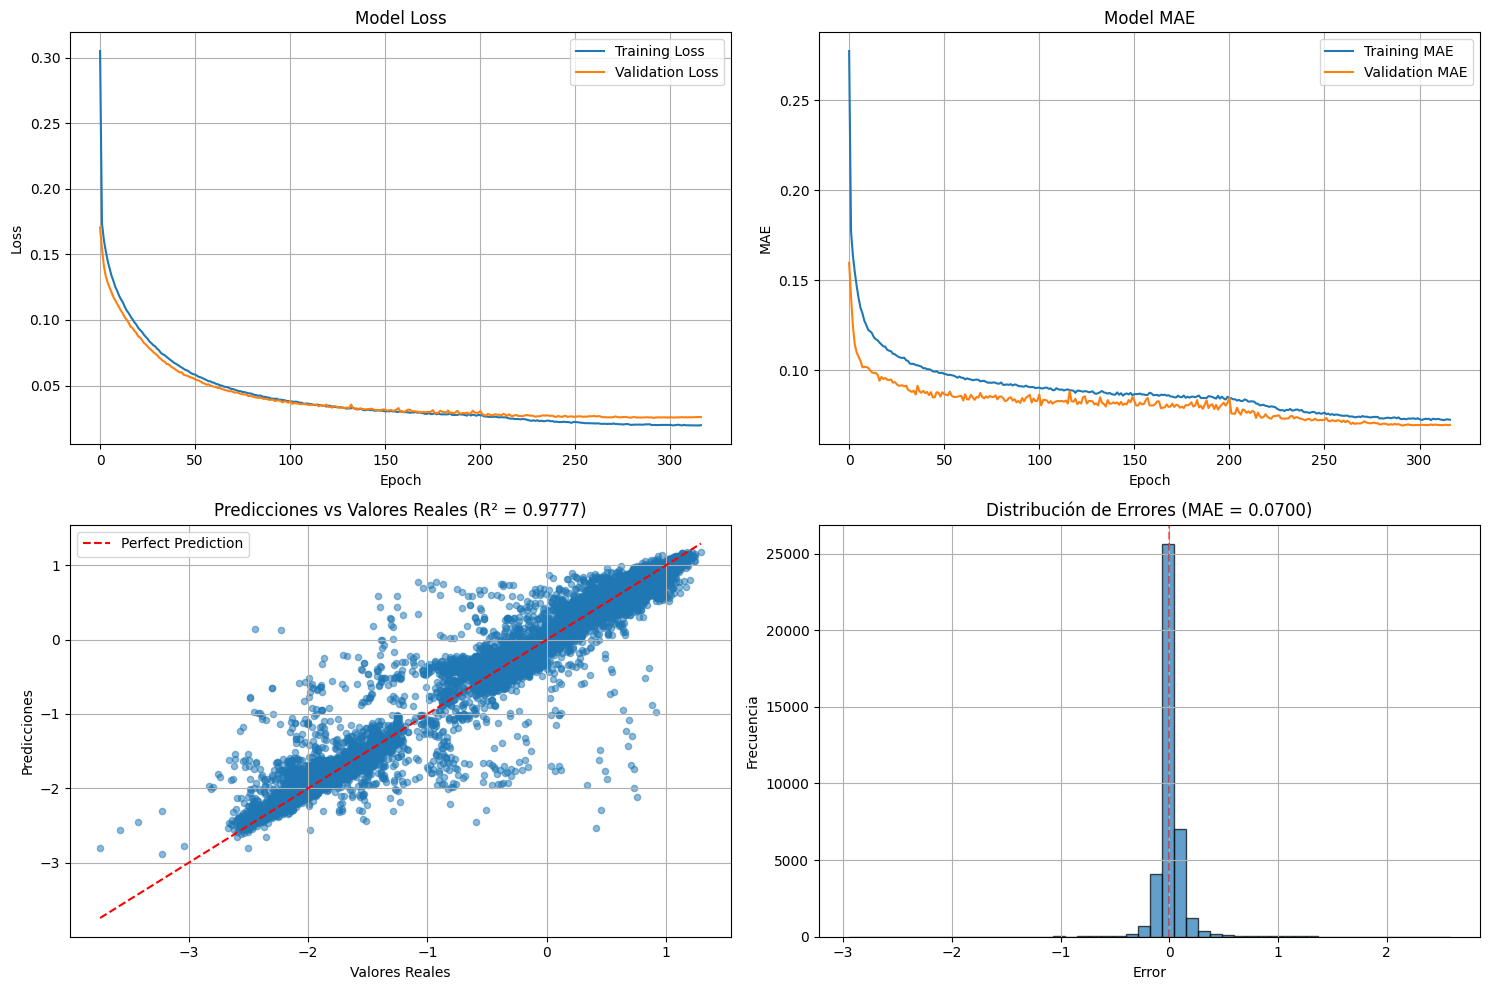

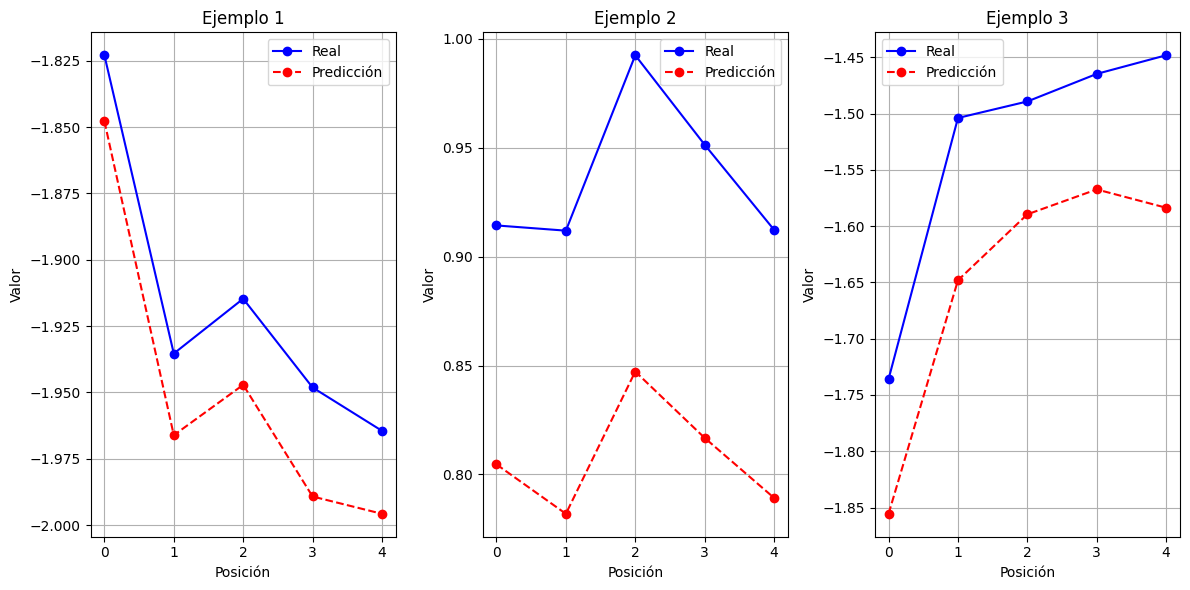

In [69]:
# ----------------------------------------
# 6. EVALUACIÓN Y VISUALIZACIÓN
# ----------------------------------------
# Evaluar
test_metrics = model.evaluate([X_test, trunk_test], Y_test, verbose=1)
print(f"\nTest loss (MSE): {test_metrics[0]:.4f}")

# Hacer predicciones
Y_pred = model.predict([X_test, trunk_test])


# Asegurar que Y_pred tenga la forma correcta (8000, 5)
if Y_pred.shape != Y_test.shape:
    Y_pred = Y_pred.reshape(Y_test.shape)


# Aplanar arrays para métricas y visualización
Y_test_flat = Y_test.ravel()
Y_pred_flat = Y_pred.ravel()


# Calcular métricas
mse = np.mean((Y_pred_flat - Y_test_flat)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(Y_pred_flat - Y_test_flat))
r2 = 1 - np.sum((Y_test_flat - Y_pred_flat)**2) / np.sum((Y_test_flat - np.mean(Y_test_flat))**2)

# [Resto del código de visualización igual que antes...]

# Imprimir métricas
print("\nMétricas de evaluación:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Visualizaciones
plt.figure(figsize=(15, 10))

# 1. Gráfico de pérdida durante el entrenamiento
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Gráfico de MAE durante el entrenamiento
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# 3. Scatter plot de predicciones vs valores reales
plt.subplot(2, 2, 3)
plt.scatter(Y_test_flat, Y_pred_flat, alpha=0.5, s=20)
min_val = min(np.min(Y_test_flat), np.min(Y_pred_flat))
max_val = max(np.max(Y_test_flat), np.max(Y_pred_flat))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Predicciones vs Valores Reales (R² = {r2:.4f})')
plt.legend()
plt.grid(True)

# 4. Histograma de errores
plt.subplot(2, 2, 4)
errors = Y_pred_flat - Y_test_flat
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.title(f'Distribución de Errores (MAE = {mae:.4f})')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualizar algunas predicciones específicas
plt.figure(figsize=(12, 6))
for i in range(3):  # Mostrar 3 ejemplos
    plt.subplot(1, 3, i+1)
    plt.plot(range(5), Y_test[i], 'bo-', label='Real')
    plt.plot(range(5), Y_pred[i], 'ro--', label='Predicción')
    plt.title(f'Ejemplo {i+1}')
    plt.xlabel('Posición')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()
